# Problema VRP Marcos
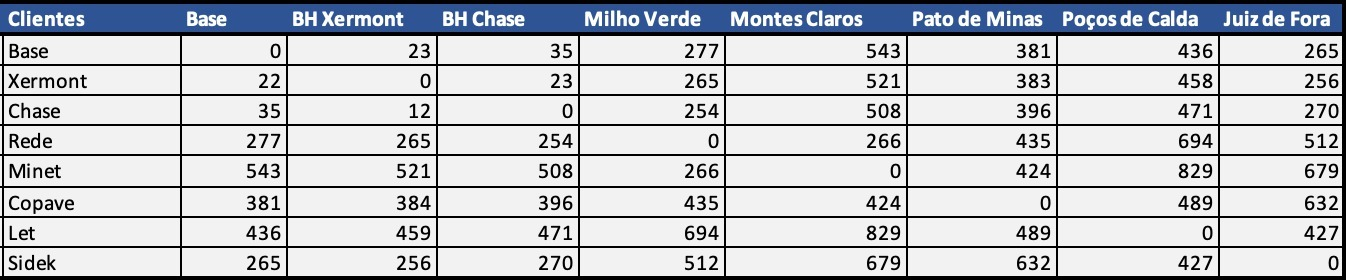

In [1]:
#Importando os pacotes
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np

In [2]:
#Creating the model
model = pyo.ConcreteModel()

In [3]:
#Criating the sets
model.i = pyo.RangeSet(1,8) #Set of Machines
cidade_i = model.i

model.j = pyo.RangeSet(1,8) #Set of Tasks
cidade_j = model.j

model.k = pyo.RangeSet(2,8)

In [4]:
#Constructing the parameters
problem = pd.read_excel('/Users/TullioPires/Python-Mestrado/MBA-Marcos.xlsx', 'Distancias', header=[0,1])

problem

Cidade origem Cidade destino                                   
  Unnamed: 0_level_1              1    2    3    4    5    6    7    8
0                  1              0   23   35  277  543  381  436  265
1                  2             22    0   23  265  521  383  458  256
2                  3             35   12    0  254  508  396  471  270
3                  4            277  265  254    0  266  435  694  512
4                  5            543  521  508  266    0  424  829  679
5                  6            381  384  396  435  424    0  489  632
6                  7            436  459  471  694  829  489    0  427
7                  8            265  256  270  512  679  632  427    0

In [6]:
problem.columns = ['cidade origem', 0,1,2,3,4,5,6,7]

cidades = problem['cidade origem']
distancias = problem.iloc[:, 1:9]

distancias.index = distancias.index + 1
distancias.columns = distancias.columns + 1

In [10]:
#Convert the DataFrame to a dictionary
distancias_dict = {(i+1, j+1): distancias.iloc[i, j] for i in range(8) for j in range(8)}

distancias_dict

{(1, 1): 0,
 (1, 2): 23,
 (1, 3): 35,
 (1, 4): 277,
 (1, 5): 543,
 (1, 6): 381,
 (1, 7): 436,
 (1, 8): 265,
 (2, 1): 22,
 (2, 2): 0,
 (2, 3): 23,
 (2, 4): 265,
 (2, 5): 521,
 (2, 6): 383,
 (2, 7): 458,
 (2, 8): 256,
 (3, 1): 35,
 (3, 2): 12,
 (3, 3): 0,
 (3, 4): 254,
 (3, 5): 508,
 (3, 6): 396,
 (3, 7): 471,
 (3, 8): 270,
 (4, 1): 277,
 (4, 2): 265,
 (4, 3): 254,
 (4, 4): 0,
 (4, 5): 266,
 (4, 6): 435,
 (4, 7): 694,
 (4, 8): 512,
 (5, 1): 543,
 (5, 2): 521,
 (5, 3): 508,
 (5, 4): 266,
 (5, 5): 0,
 (5, 6): 424,
 (5, 7): 829,
 (5, 8): 679,
 (6, 1): 381,
 (6, 2): 384,
 (6, 3): 396,
 (6, 4): 435,
 (6, 5): 424,
 (6, 6): 0,
 (6, 7): 489,
 (6, 8): 632,
 (7, 1): 436,
 (7, 2): 459,
 (7, 3): 471,
 (7, 4): 694,
 (7, 5): 829,
 (7, 6): 489,
 (7, 7): 0,
 (7, 8): 427,
 (8, 1): 265,
 (8, 2): 256,
 (8, 3): 270,
 (8, 4): 512,
 (8, 5): 679,
 (8, 6): 632,
 (8, 7): 427,
 (8, 8): 0}

In [12]:
# Creating Pyomo parameter from numpy array
model.distance = pyo.Param(model.i, model.j, initialize=distancias_dict)
model.distance.pprint()

distance : Size=64, Index=distance_index, Domain=Any, Default=None, Mutable=False
    Key    : Value
    (1, 1) :     0
    (1, 2) :    23
    (1, 3) :    35
    (1, 4) :   277
    (1, 5) :   543
    (1, 6) :   381
    (1, 7) :   436
    (1, 8) :   265
    (2, 1) :    22
    (2, 2) :     0
    (2, 3) :    23
    (2, 4) :   265
    (2, 5) :   521
    (2, 6) :   383
    (2, 7) :   458
    (2, 8) :   256
    (3, 1) :    35
    (3, 2) :    12
    (3, 3) :     0
    (3, 4) :   254
    (3, 5) :   508
    (3, 6) :   396
    (3, 7) :   471
    (3, 8) :   270
    (4, 1) :   277
    (4, 2) :   265
    (4, 3) :   254
    (4, 4) :     0
    (4, 5) :   266
    (4, 6) :   435
    (4, 7) :   694
    (4, 8) :   512
    (5, 1) :   543
    (5, 2) :   521
    (5, 3) :   508
    (5, 4) :   266
    (5, 5) :     0
    (5, 6) :   424
    (5, 7) :   829
    (5, 8) :   679
    (6, 1) :   381
    (6, 2) :   384
    (6, 3) :   396
    (6, 4) :   435
    (6, 5) :   424
    (6, 6) :     0
    (6, 7) :   489
    (6

In [13]:
#Creating variables
model.x = pyo.Var(model.i, model.j, domain = pyo.Binary, doc='Cidade i - Cidade j')
x = model.x

model.u = pyo.Var(model.i, domain = pyo.NonNegativeIntegers, doc='Variáveis auxiliares'
                  ,bounds=(0, 7))
u = model.u

In [14]:
#Restrições
#Restrição de entrada nos nós
def rule_constraint1(model, i):
  return sum(x[i,j] for j in model.j if j!=i) == 1

model.constraint1 = pyo.Constraint(model.i, rule=rule_constraint1, doc='Restrição de entrada nos nós')

In [15]:
#Restrição de saída dos nós
def rule_constraint2(model, j):
  return sum(x[i,j] for i in model.i if i!=j) == 1

model.constraint2 = pyo.Constraint(model.j, rule=rule_constraint2, doc='Restrição de entrada nos nós')

In [16]:
#Restrição de percurso - que os veículos não voltam
def rule_constraint3(model, i, j):
  if i!=j:
    return u[i] - u[j] + x[i,j]*8 <= 7
  else:
    return u[i] - u[i] == 0

model.constraint3 = pyo.Constraint(model.k, model.j, rule=rule_constraint3, doc='restrição de não volta')

In [17]:
#Gerando a função objetivo
def fun_obj(model):
  return sum(x[i,j]*model.distance[i,j] for i in model.i for j in model.j if i!=j)

model.Objective = pyo.Objective(rule=fun_obj, sense=pyo.minimize, doc='Função Objetivo')

In [18]:
#Solves
solver = SolverFactory('glpk')
result = solver.solve(model,tee = False)

#Prints the results
print(result)


Problem: 
- Name: unknown
  Lower bound: 2159.0
  Upper bound: 2159.0
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 65
  Number of nonzeros: 260
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 5
      Number of created subproblems: 5
  Error rc: 0
  Time: 0.0238950252532959
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [19]:
print('Objective Function = ',model.Objective())

Objective Function =  2159.0


In [20]:
# Getting the ordered route
route = []
current_city = 1  # we start from city 1
while True:
    # find the city that current_city is connected to
    for j in model.j:
        if current_city != j and pyo.value(model.x[current_city,j]) > 0.5:
            next_city = j
            break
    route.append((current_city, next_city))
    current_city = next_city
    if current_city == 1:
        break  # if we are back in the starting city, the route is complete

# Printing the route
print('The optimal route is:')
for i, j in route:
    print(f'from city {i} to city {j}')

The optimal route is:
from city 1 to city 8
from city 8 to city 7
from city 7 to city 6
from city 6 to city 5
from city 5 to city 4
from city 4 to city 3
from city 3 to city 2
from city 2 to city 1
